# Защита персональных данных клиентов

**Описание задания:**

Необходимо защитить данные клиентов страховой компании «Хоть потоп».

Нужно разработать такой метод преобразования данных, чтобы было трудно восстановить личную информацию и обосновать корректность его работы.
При этом, необходимо так защитить данные, чтобы качество моделей машинного обучения не ухудшилось при трансформации.

В качестве модели машинного обучения используется линейная регрессия.

**Описание набора данных**

  - **Независимые признаки:** пол, возраст и зарплата застрахованного, количество членов его семьи;
  -   **Целевой признак:** количество страховых выплат клиенту за последние 5 лет.

**Цель работы** — разработать метод преобразования данных, защищающий личную информацию клиентов страховой компании «Хоть потоп» и не влияющий на работу модели линейной регрессии.

**Работа будет проводиться в следующие 5 этапов:**

1. Исследовательских анализ и предварительная обработка данных;
2. Построение модели линейной регрессии и анализ влияния матричных операций над датасетом на качество модели;
3. Алгоритм преобразования датасета для защиты персональных данных клиентов компании;
4. Применение и проверка алгоритма защиты персональных данных;
5. Проверка корректности разработанной модели линейной регрессии с аналогичной моделью из библиотеки SKlearn.

# Библиотеки

In [1]:
import os

import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as SklearnLR
from sklearn.metrics import r2_score

# Константы и настройки

In [2]:
DATA_PATH1 = 'insurance.csv'
DATA_PATH2 = '/datasets/insurance.csv'

RANDOM_STATE = 42
TEST_SIZE = 0.25

SCALER = MinMaxScaler()


sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')

# Функции

In [3]:
def analyze_dataframe(df, asc=False):
    unique_values = []
    for i in df.columns:
        unique_values.append(df[i].sort_values(ascending=asc).unique())  # asc

    table_scan = pd.DataFrame(
        {
            'values_num': df.count(),
            'nulls_num': df.isna().sum(),
            'completeness': 100 - (df.isna().sum() / (df.isna().sum() + df.notna().sum()) * 100),
            'uniques_num': df.nunique(),
            'unique_values': unique_values,
            'dtype': df.dtypes
        }
    )

    memory = df.memory_usage(index=False).sum() / 1_000_000

    print('General data analysis:')
    print()
    print('Shape of the table:     ', df.shape)
    print(f'Duplicates in the table: {df.duplicated().sum()}, ({round(df.duplicated().sum() / df.shape[0], 4) * 100}%)')
    print('Memory usage:            ' + str(round(memory, 1)) + '+ MB')
    print()
    return table_scan


def create_visualization(data, dtype, target, figsize=None, bins=50):
    if dtype == 'numbers':
        target_nunique = data[target].nunique()

        print('Visualization of quantitative features distribution:')
        print()

        if target_nunique <= 10:
            for i in data.drop(target, axis=1):
                if data[i].dtype != 'O' and data[i].unique().shape[0] > 10:
                    print(f'Feature: {i}')

                    figure, (ax_box, ax_hist) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': (.25, .75)},
                                                             figsize=(9, 7) if figsize is None else figsize)

                    sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

                    sns.boxplot(data=data, x=i, y=target, orient='h', ax=ax_box).set_title(i, y=1.5, fontsize=14)
                    sns.histplot(data=data, x=i, hue=target, kde=True, bins=bins)

                    plt.show()
                    print()
                    print('Feature statistics:')
                    display(pd.DataFrame(data[i].describe()).apply(round, args=[2]))
        else:
            for i in data.drop(target, axis=1):
                if data[i].dtype != 'O' and data[i].unique().shape[0] > 10:
                    print(f'Feature: {i}')

                    figure, (ax_box, ax_hist) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': (.25, .75)},
                                                             figsize=(9, 7) if figsize is None else figsize)

                    sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

                    sns.boxplot(data=data, x=i, ax=ax_box).set_title(i, y=1.5, fontsize=14)
                    sns.histplot(data=data, x=i, kde=True, bins=bins)

                    plt.show()
                    print()
                    print('Feature statistics:')
                    display(pd.DataFrame(data[i].describe()).apply(round, args=[2]))
    elif dtype == 'categories':
        print('Visualization of categorical features and target prevalence:')
        print()

        for i in data.drop(target, axis=1):
            if data[i].dtype == 'O' or data[i].unique().shape[0] <= 10:
                bar_data = data[i].value_counts().reset_index().rename(
                    columns={'index': data[i].name, data[i].name: 'Count'}).sort_values(by=i)

                prev_data = (data.groupby([i])[target]
                             .value_counts(normalize=True)
                             .reset_index(name='prevalance'))
                prev_data['prevalance'] = prev_data['prevalance'].round(4) * 100

                print(f'Feature: {i}')

                figure, (ax_bar, ax_prev) = plt.subplots(1, 2, figsize=(18, 5) if figsize is None else figsize)

                sns.barplot(data=bar_data, x=i, y='Count',
                            linewidth=0.5, ax=ax_bar, color='#CC8963').set_title(f'{i} distribution', y=1.02, fontsize=14)
                try:
                    sns.barplot(data=prev_data, x=i, y='prevalance', hue=target,
                                linewidth=0.5, palette={0: '#008744', 1: '#d62d20'},
                                ax=ax_prev).set_title(f'target prevalence, %', y=1.02, fontsize=14)
                except:
                    sns.barplot(data=prev_data, x=i, y='prevalance', hue=target,
                                ax=ax_prev).set_title(f'target prevalence, %', y=1.02, fontsize=14)

                r_ = 0 if bar_data.shape[0] < 5 else 90
                ax_bar.tick_params(axis='x', rotation=r_)
                ax_prev.tick_params(axis='x', rotation=r_)

                plt.show()
                print()
    elif dtype == 'target':
        print('Visualization of target distribution:')
        print()
        print(f'Target: {target}')

        if data[target].unique().shape[0] <= 10:
            plt.figure(figsize=(5, 5) if figsize is None else figsize)

            target_ = data[target].value_counts().reset_index().rename(
                columns={'index': data[target].name, data[target].name: 'Count'})

            sns.barplot(
                data=target_,
                x=target, y='Count'
            ).set_title(target, y=1.02, fontsize=14)

            plt.show()
            print()
            print('Target statistics:')
            display(pd.DataFrame(data[target].describe()))
        else:
            print('Visualization of target distribution:')
            print()
            print(f'Target: {target}')

            figure, (ax_box, ax_hist) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': (.25, .75)},
                                                     figsize=(9, 7) if figsize is None else figsize)

            sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

            sns.boxplot(data=data, x=target, ax=ax_box).set_title(target, y=1.5, fontsize=14)
            sns.histplot(data=data, x=target, kde=True, bins=bins)

            plt.show()
            print()
            print('Feature statistics:')
            display(pd.DataFrame(data[target].describe()))

    print()


def get_corr_map(df, method='pearson', figisze=(15, 12)):
    plt.figure(figsize=figisze)

    sns.heatmap(
        round(df.corr(method=method), 2), vmax=1, vmin=-1, square=True, linewidths=3, annot=True, cmap='coolwarm'
    )

    plt.show()


def get_samples(ds, target_ind, print_res, test_size=TEST_SIZE, random_state=RANDOM_STATE):
    X = ds[:, :target_ind]
    y = ds[:, target_ind]

    try:
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y)
    except:
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=test_size, random_state=random_state)

    samples = {
        'X_train': X_train,
        'X_val': X_val,
        'y_train': y_train,
        'y_val': y_val
    }

    if print_res:
        print(f'Share of validation sample: {test_size * 100} %')
        print('The shape of the training set for independent features:  ', X_train.shape)
        print('The shape of the training set for target:                ', y_train.shape)
        print()
        print('The shape of the validation set for independent features:', X_val.shape)
        print('The shape of the validation set for target:              ', y_val.shape)

    return samples


def normalize_samples(samples, scaler=SCALER):
    scaler.fit(samples['X_train'])

    res = {
        'X_train': scaler.transform(samples['X_train']),
        'X_val': scaler.transform(samples['X_val']),
        'y_train': samples['y_train'],
        'y_val': samples['y_val']
    }

    return res


def get_prediction(ds, target_ind, model, print_res, test_size=TEST_SIZE, random_state=RANDOM_STATE, scaler=SCALER):
    normalized_samples = normalize_samples(
        get_samples(
            ds=ds, target_ind=target_ind, print_res=print_res,
            test_size=test_size, random_state=random_state
        ), scaler=scaler)

    X_train = normalized_samples['X_train']
    X_val = normalized_samples['X_val']
    y_train = normalized_samples['y_train']
    y_val = normalized_samples['y_val']

    model = model

    model.fit(X_train, y_train)

    # zeros_correction = np.vectorize(lambda x: 0 if x < 0 else x)
    preds_correction = np.vectorize(lambda x: round(abs(x)))
    train_preds = preds_correction(model.predict(X_train))
    val_preds = preds_correction(model.predict(X_val))

    metrics = {
        'train': r2_score(train_preds, y_train),
        'val': r2_score(val_preds, y_val)
    }

    if print_res:
        print('Training R2 score:  ', metrics['train'])
        print('Validation R2 score:', metrics['val'])

    return metrics


def get_inv_matrix(dim):
    det = 0
    while det == 0:
        matrix = np.random.normal(size=(dim, dim))
        det = np.linalg.det(matrix)
    return matrix


def encrypt_ds(ds, target_ind):
    key = get_inv_matrix(target_ind)

    encrypted_ds = ds[:, :target_ind] @ key
    encrypted_ds = np.column_stack((encrypted_ds, ds[:, target_ind]))

    return encrypted_ds, key

# Класс Линейной Регрессии

**Линейная регрессия** - это статистический метод для анализа зависимости одной количественной переменной от одной или нескольких других количественных переменных в виде линейной функции $Xw + w0$.

Используя набор данных, можно оценить параметры этой функции и использовать ее для прогнозирования значений зависимой переменной на основе значений независимых переменных.

**Математическое описание линейной регрессии:**

> **Предсказние модели:** $a = Xw + w0$
> **Задача обучения:** $w = \arg\min_w MSE(Xw, y)$
> **Формула обучения:** $w = (X^T X)^{-1} X^T y$
> **Величина сдвига:** $w0 = w_0$

Опишем класс для модели линейной регрессии.

In [4]:
class LinearRegression:
    def __init__(self):
        self.w = None
        self.w0 = None

    def fit(self, X_train, y_train):
        X_train = np.concatenate((np.ones((X_train.shape[0], 1)), X_train), axis=1)

        w = (np.linalg.inv(X_train.T @ X_train) @ X_train.T) @ y_train
        self.w0 = w[0]
        self.w = w[1:]

    def predict(self, test_features):
        return test_features @ self.w + self.w0

    @property
    def weights(self):
        return self.w, self.w0

Этот класс представляет собой реализацию линейной регрессии, метода, используемого для прогнозирования числовых значений с учетом набора входных признаков.

Данный класс имеет следующие методы:

1. **`Метод __init__`**, который устанавливает атрибут `вектора весов w` и атрибута `скаляра смещения w0`.
2. **`Метод fit`**, который принимает обучающую выборку и решает для неё задачу обучения модели, вычисляя наиболее оптимальный `вектор весов w` и `скаляр смещения w0`.
3. **`Метод predict`**, который принимает валидационную выборку и решает задачу предсказания модели.
4. **`Свойство weights`**, которое позволяет получить доступ к весам, вычисленным во время обучения `методом fit`.

# Исследовательский анализ данных и их предобработка

## Загрузка данных

In [5]:
if os.path.exists(DATA_PATH1):
    data = pd.read_csv(DATA_PATH1)
elif os.path.exists(DATA_PATH2):
    data = pd.read_csv(DATA_PATH2)
else:
    print("Path doesn't exist!")

data

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0


## Верхнеуровневый анализ данных и первичная предобработка

### Верхнеуровневый анализ

In [6]:
analyze_dataframe(data)

General data analysis:

Shape of the table:      (5000, 5)
Duplicates in the table: 153, (3.06%)
Memory usage:            0.2+ MB



,values_num,nulls_num,completeness,uniques_num,unique_values,dtype
Пол,5000,0,100.0,2,"[1, 0]",int64
Возраст,5000,0,100.0,46,"[65.0, 62.0, 61.0, 60.0, 59.0, 58.0, 57.0, 56....",float64
Зарплата,5000,0,100.0,524,"[79000.0, 75200.0, 74800.0, 71600.0, 71400.0, ...",float64
Члены семьи,5000,0,100.0,7,"[6, 5, 4, 3, 2, 1, 0]",int64
Страховые выплаты,5000,0,100.0,6,"[5, 4, 3, 2, 1, 0]",int64


При первичном ознакомлении и высокоуровневом анализе данных можно выделить следующие моменты, требующие обработки:

1. В данных присутствует 153 дубликата;
2. Имена полей пишутся кириллицей с использованием разных регистров. В именах также присутствуют пробелы;
3. Используемые типы данных требуют чрезмерного объема памяти.

Решим данные моменты.

### Удаление дубликатов из данных

In [7]:
data = data.drop_duplicates().reset_index(drop=True)

print('Duplicates in data after processing:', data.duplicated().sum())

Duplicates in data after processing: 0


### Приведение названий полей к единому стилю

In [8]:
data = data.rename(
    columns={
        'Пол':               'gender',
        'Возраст':           'age',
        'Зарплата':          'wage',
        'Члены семьи':       'family_members',
        'Страховые выплаты': 'insurance_payments'
    }
)

print('Сolumn names after processing:')
data.columns

Сolumn names after processing:


Index(['gender', 'age', 'wage', 'family_members', 'insurance_payments'], dtype='object')

### Приведение типов данных к менее ресурсоемким

In [9]:
memory_before = data.memory_usage(index=False).sum()

data = data.astype(
    {
        'gender':             'int8',
        'age':                'int8',
        'wage':               'int32',
        'family_members':     'int8',
        'insurance_payments': 'int8'
    }
)

memory_after = data.memory_usage(index=False).sum()
memory_percent = round((memory_before - memory_after) / memory_before * 100, 2)

print(f'Memory usage reduced by {memory_percent}%')
print()

analyze_dataframe(data)

Memory usage reduced by 80.0%

General data analysis:

Shape of the table:      (4847, 5)
Duplicates in the table: 0, (0.0%)
Memory usage:            0.0+ MB



,values_num,nulls_num,completeness,uniques_num,unique_values,dtype
gender,4847,0,100.0,2,"[1, 0]",int8
age,4847,0,100.0,46,"[65, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 5...",int8
wage,4847,0,100.0,524,"[79000, 75200, 74800, 71600, 71400, 70600, 705...",int32
family_members,4847,0,100.0,7,"[6, 5, 4, 3, 2, 1, 0]",int8
insurance_payments,4847,0,100.0,6,"[5, 4, 3, 2, 1, 0]",int8


Теперь данные готовы для исследовательского анализа.

## Исследовательский анализ данных

### Анализ количественных параметров

Visualization of quantitative features distribution:

Feature: age


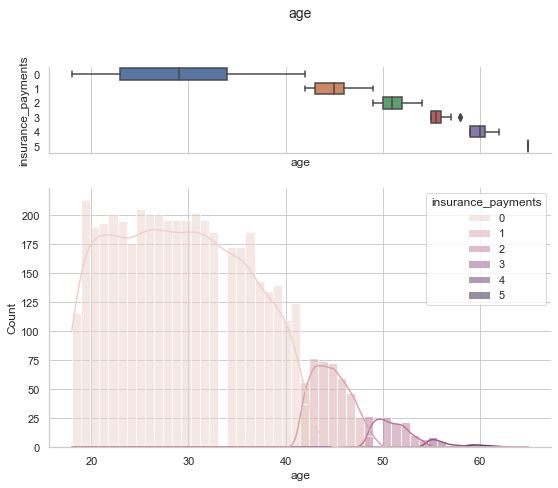


Feature statistics:


,age
count,4847.00
mean,31.02
std,8.49
min,18.00
25%,24.00
50%,30.00
75%,37.00
max,65.00


Feature: wage


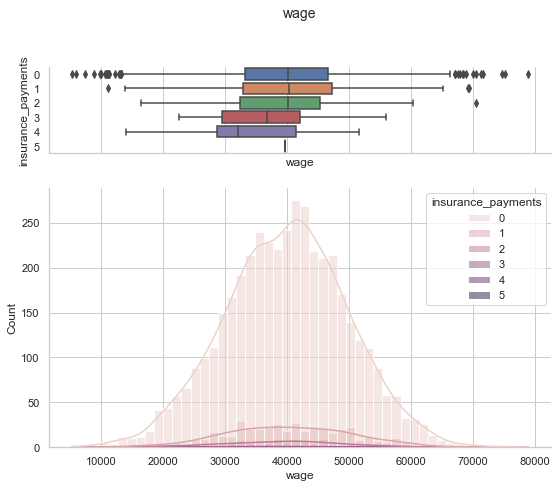


Feature statistics:


,wage
count,4847.00
mean,39895.81
std,9972.95
min,5300.00
25%,33200.00
50%,40200.00
75%,46600.00
max,79000.00


In [10]:
create_visualization(data=data, dtype='numbers', target='insurance_payments')

### Анализ категориальных параметров

Visualization of categorical features and target prevalence:

Feature: gender


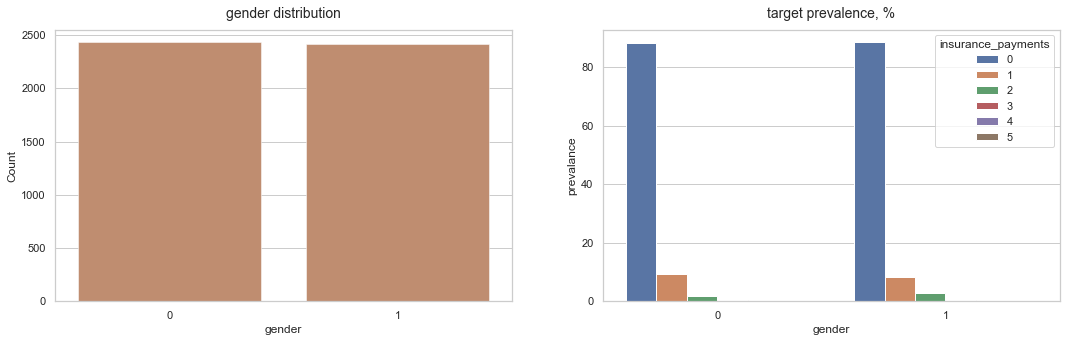


Feature: family_members


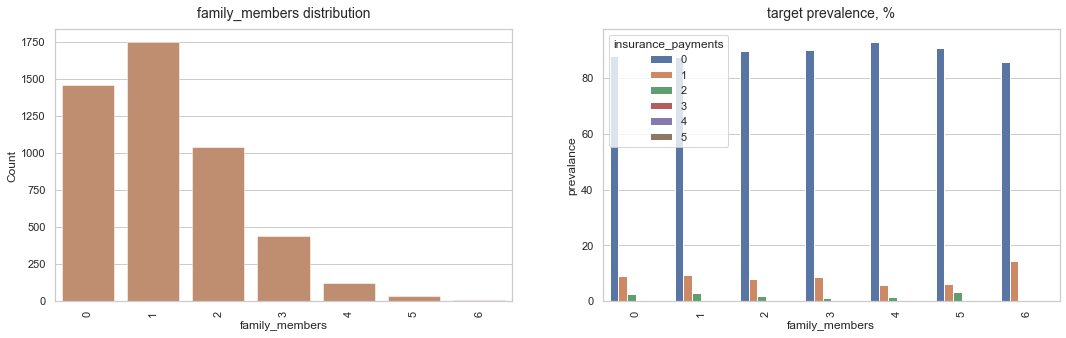

In [11]:
create_visualization(data=data, dtype='categories', target='insurance_payments')

### Исследовательский анализ целевого признака

Visualization of target distribution:

Target: insurance_payments


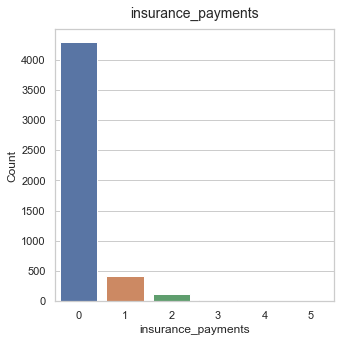


Target statistics:


,insurance_payments
count,4847.000000
mean,0.152259
std,0.468934
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,5.000000


In [12]:
create_visualization(data=data, dtype='target', target='insurance_payments')

In [13]:
data['insurance_payments'].value_counts()

0    4284
1     423
2     114
3      18
4       7
5       1
Name: insurance_payments, dtype: int64

### Корреляция между независимыми и целевым параметрами

#### Корреляция Пирсона

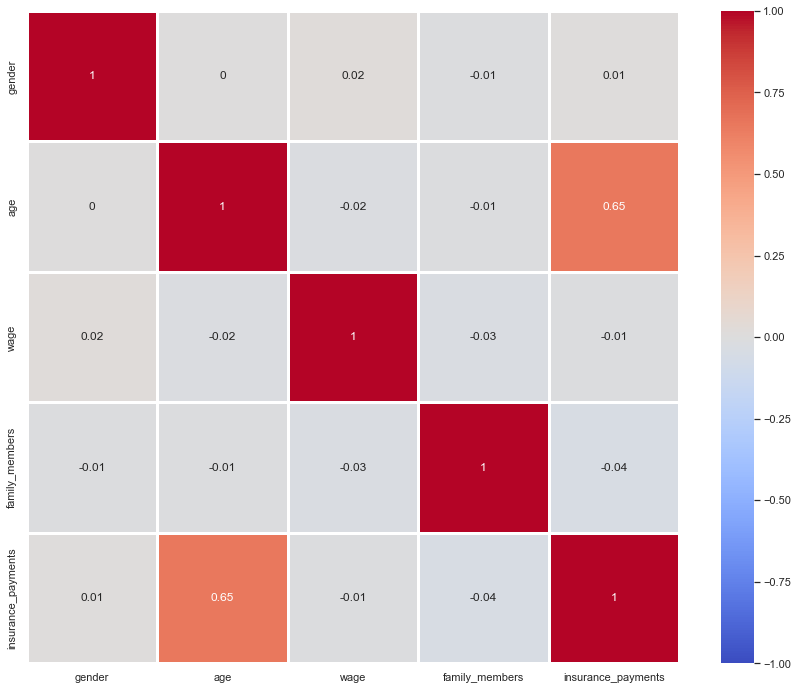

In [14]:
get_corr_map(data)

#### Корреляция Спирмана

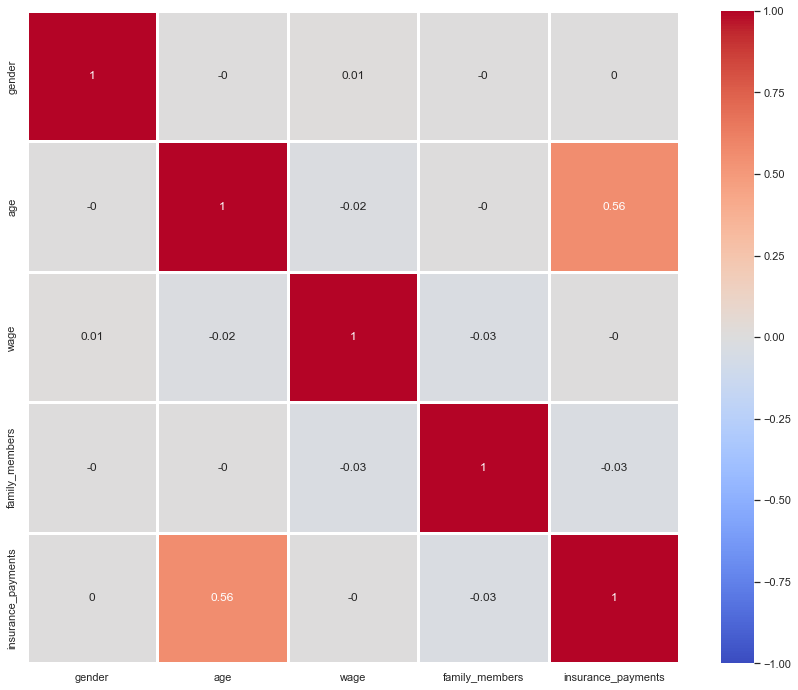

In [15]:
get_corr_map(df=data, method='spearman')

### Визуализация данных с помощью парных графиков

Parameters pairplots:


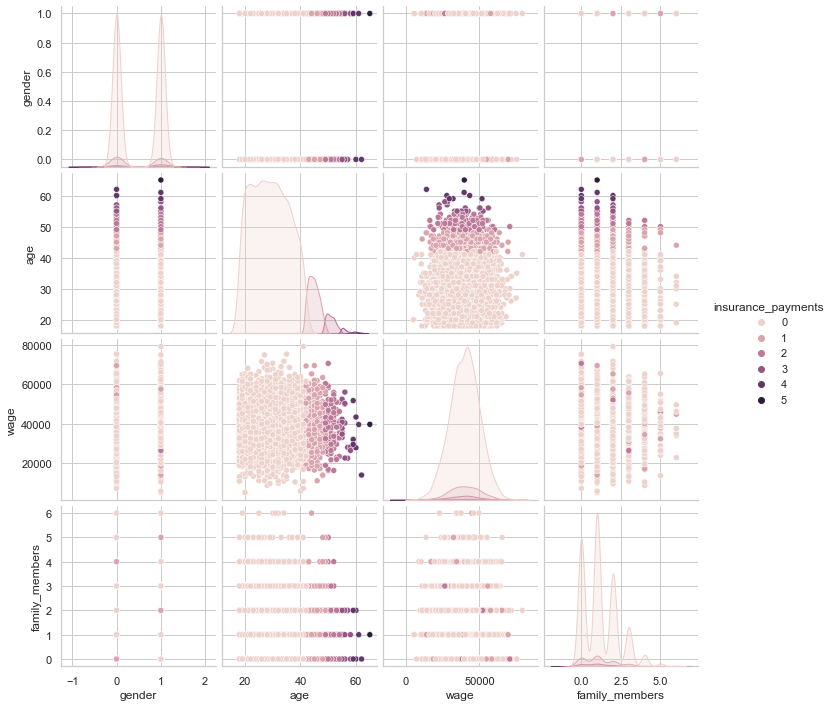

In [16]:
print('Parameters pairplots:')

sns.pairplot(data, hue='insurance_payments')
plt.show()

Можно сделать следующие выводы:

1. Распределение количественных параметров ненормальное, в данных присутствуют выбросы;
2. Целевой признак очень сильно зависит от возраста заказчика, что четко прослеживается в сформированных на графиках группах, а также подтверждается корреляционным анализом параметров;
3. Другие параметры не показывают корреляции с целевым признаком. Мультиколлинеарность в данных отсутствует;
4. Целевой признак крайне несбалансирован: значения больше 2 составляют всего 0,52% от общего количества данных, что оправдывает отбрасывание наблюдений с этими значениями целевого признака.

## Предобработка данных

Удалим наблюдения из набора данных, где значение целевого признака больше 2.

In [17]:
data = (data.query('insurance_payments < 3')
        .reset_index(drop=True))

data['insurance_payments'].value_counts()

0    4284
1     423
2     114
Name: insurance_payments, dtype: int64

## Конвертация данных в матричное представление

Для достижения поставленной цели, переведем данные в матрицу для возможности осуществления матричных операций, позволяющих зашифровать данные.

In [18]:
ds = data.to_numpy()

print('Dataset in matrix representation')
ds

Dataset in matrix representation


array([[    1,    41, 49600,     1,     0],
       [    0,    46, 38000,     1,     1],
       [    0,    29, 21000,     0,     0],
       ...,
       [    0,    20, 33900,     2,     0],
       [    1,    22, 32700,     3,     0],
       [    1,    28, 40600,     1,     0]], dtype=int32)

# Построение модели линейной регрессии и анализ влияния матричных операций над датасетом на качество модели

Для защиты клиентских данных с помощью шифрования данных, можно использовать метод шифрования данных, основанном на умножении данных на обратимую матрицу.

В данном методе используется преобразование вида:

$$X' = XP$$

где:
 - $X$ - матрица размерностью $m×n$
 - $P$ - обратимая матрица, размерностью $n×n$.

`Обратимая матрица` - матрица $P$, для которой возможно найти такую матрицу $P^{-1}$, при умножении на которую исходную матрицу $P$ получается единичная матрица $E$:

 $${\displaystyle PP^{-1}=P^{-1}P=E.}$$

Матрица обратима тогда и только тогда, когда она [невырождена](https://ru.wikipedia.org/wiki/%D0%92%D1%8B%D1%80%D0%BE%D0%B6%D0%B4%D0%B5%D0%BD%D0%BD%D0%B0%D1%8F_%D0%BC%D0%B0%D1%82%D1%80%D0%B8%D1%86%D0%B0 "Вырожденная матрица"), то есть её определитель не равен нулю.

Умножение признаков на обратимую матрицу не изменит качество модели линейной регрессии. Это связано с тем, что модель линейной регрессии находит наилучшую линейную комбинацию входных признаков для прогнозирования выходной переменной. Умножение объектов на обратимую матрицу просто изменяет масштаб или поворот входного пространства, но не влияет на лежащую в основе взаимосвязь между входными объектами и выходной переменной.

**Тем не менее, проверим данное утверждение, ответив на следующий вопрос: `Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии?`.**

Для ответа на данный вопрос выполним следующие действия:
1. Определим результат модели линейной регрессии на оригинальном датасете. В качестве метрики будем использовать `R2-score`;
2. Зашифруем независимые признаки, умножив их на обратимую матрицу;
3. Определим результат модели на преобразованном датасете;
4. Сгруппируем результаты и ответим на вопрос.

### Результат модели линейной регрессии на оригинальном датасете

In [19]:
lr_res = get_prediction(ds=ds, target_ind=4, model=LinearRegression(), print_res=True)

Share of validation sample: 25.0 %
The shape of the training set for independent features:   (3615, 4)
The shape of the training set for target:                 (3615,)

The shape of the validation set for independent features: (1206, 4)
The shape of the validation set for target:               (1206,)
Training R2 score:   0.6020353302611368
Validation R2 score: 0.680952380952381


### Умножение независимых признаков на обратимую матрицу

Сгенерируем обратимую матрицу, состоящую из случайных элементов нормального распределения.

In [20]:
P = get_inv_matrix(ds.shape[1] - 1)

print('Invertible matrix multiplier:')
P

Invertible matrix multiplier:


array([[-0.32754306, -0.22694746, -0.85094528,  0.2637113 ],
       [-1.04309919,  1.30359647,  0.19096643,  0.124354  ],
       [-1.35312418,  1.48212396,  0.45762278,  0.21038093],
       [-0.71533543,  0.27867   , -0.39843572,  0.82805439]])

Преобразуем независимые признаки датасета, умножив их на сгенерированную матрицу `P`.

In [21]:
multiplied_ds = ds[:, :4] @ P
multiplied_ds = np.column_stack((multiplied_ds, ds[:, 4]))

print('Multiplied dataset:')
multiplied_ds

Multiplied dataset:


array([[-6.71587693e+04,  7.35668477e+04,  2.27046703e+04,
         1.04410845e+04,  0.00000000e+00],
       [-5.14674167e+04,  5.63809547e+04,  1.73980518e+04,
         8.00102373e+03,  1.00000000e+00],
       [-2.84458576e+04,  3.11624075e+04,  9.61561646e+03,
         4.42160582e+03,  0.00000000e+00],
       ...,
       [-4.58932023e+04,  5.02706316e+04,  1.55164348e+04,
         7.13605676e+03,  0.00000000e+00],
       [-4.42725824e+04,  4.84947418e+04,  1.49664200e+04,
         6.88494012e+03,  0.00000000e+00],
       [-5.49670913e+04,  6.02107853e+04,  1.85835827e+04,
         8.54603949e+03,  0.00000000e+00]])

### Результат модели линейной регрессии на преобразованном датасете

In [22]:
lr_res_multiplied = get_prediction(ds=multiplied_ds, target_ind=4, model=LinearRegression(), print_res=True)

Share of validation sample: 25.0 %
The shape of the training set for independent features:   (3615, 4)
The shape of the training set for target:                 (3615,)

The shape of the validation set for independent features: (1206, 4)
The shape of the validation set for target:               (1206,)
Training R2 score:   0.6020353302611368
Validation R2 score: 0.680952380952381


### Группировка результатов и рассмотрение связи параметров модели в исходной задаче и в преобразованной

In [23]:
result = pd.DataFrame(
    {
        'default_ds': [lr_res['train'], lr_res['val']],
        'multiplied_ds': [lr_res_multiplied['train'], lr_res_multiplied['val']]
    }, index=['Training R2 score', 'Validation R2 score']
)

result

,default_ds,multiplied_ds
Training R2 score,0.602035,0.602035
Validation R2 score,0.680952,0.680952


Как видно из результатов метрики `R2` линейная регрессия работает с одинаковой эффективностью на оригинальном и зашифрованном датасете.

**Можно дать следующий ответ на поставленный ранее вопрос: `Качество линейной модели не меняется при матричных преобразованиях`.**

**Это объясняется следующей взаимосвязью параметров линейной регрессии в исходной задаче и в преобразованной:**

В линейной регрессии параметры (то есть коэффициенты и точка пересечения) определяются путем минимизации `остаточной суммы квадратов (RSS)` между прогнозируемым выходом и истинным выходом. Модель линейной регрессии может быть представлена уравнением:

$$a = Xw + w0$$

Если мы умножим исходные входные признаки $X$ на обратимую матрицу $P$, мы получим новый набор преобразованных признаков $X' = XP$. Модель линейной регрессии преобразованных признаков может быть представлена уравнением:

$$a = XP\cdot wP + w0$$

Связь между параметрами исходных объектов и параметрами преобразованных объектов задается следующим образом:

$$wP = P^{-1}*w$$

- где $P^{-1}$ — обратная матрица $P$

Следовательно, если матрица $P$ известна, мы можем получить параметры исходных признаков из параметров преобразованных признаков, и наоборот. Это связано с тем, что `RSS` одинакова как для исходных, так и для преобразованных признаков, а параметры выбраны так, чтобы минимизировать `RSS`.

Однако это может изменить интерпретацию коэффициентов модели линейной регрессии. Например, если признак умножается на 2, коэффициент этого признака также будет умножен на 2.
Поэтому нужно быть осторожным при интерпретации коэффициентов модели линейной регрессии после применения любой обратимой матрицы.

## Математическое доказательство неизменности качества модели при проведении матричных преобразованиях датасета

**Приведем математическое доказательство вышесказанного:**

Для вычисления `вектора весов w` на оригинальном датасете решается следующая задача вычисления $w$:

$$
w = \arg\min_w MSE(Xw, y)
$$

Для вычисления `вектора весов w` на преобразованном датасете решается задача нахождения $w_P$:

$$
w_P = \arg\min_w MSE(XPw_p, y)
$$

Сделаем замену   $w_P$ на $P^{-1}w$ и подставим в задачу:

$$
\arg\min_w MSE(XPP^{-1}w, y)
$$

Что сводится к исходной задаче:

$$
\arg\min_w MSE(Xw, y)
$$

**Приведем это доказательство с помощью матричных преобразований.**

Поскольку вектор весов $w$ вычисляется как: $w = (X^T X)^{-1} X^T y$, значит $w' = ((XP)^T XP)^{-1} (XP)^T y$

Сначала раскроем под знаком транспонирования $w' = (P^T X^T X P)^{-1} (XP)^T y$ и можем увидеть три квадратные матрицы $P^T, (X^T X), P$.

Для раскрытия скобок используем правило:

$$
(ABC)^{-1} = C^{-1}(AB)^{-1} = (BC)^{-1}A^{-1} = C^{-1}B^{-1}A^{-1}
$$

следовательно раскрываем следующим образом: $w' = P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y$

Так как $w = (X^T X)^{-1} X^T y$, то $w' = P^{-1}w$

И так как $a' = X\cdot P\cdot w'$, то $a' = X\cdot P\cdot P^{-1}w$

Отсюда следуюет, что $a' = X\cdot w$

Таким образом $a' = a$



# Алгоритм преобразования датасета для защиты персональных данных клиентов компании

Поскольку метод преобразования данных подходит под условия задачи, опишем алгоритм шифрования данных для компании:
1. Генерация ключа - квадратной матрицы из случайных элементов нормального распределения размерностью $n×n$, где n - количество `независимых параметров датасета`;
2. Проверка ключа на обратимость;
3. Шифрование `независимых признаков` с помощью умножения матрицы признаков на ключ;
4. Добавление к зашифрованным признакам `целевого признака`.

Схематично данный алгоритм отражен на рисунке ниже.

![ваыва](https://i.ibb.co/Lk8yVdy/image.png)

# Применение и проверка алгоритма защиты персональных данных

In [24]:
encrypted_ds, key = encrypt_ds(ds, 4)

print('Encrypted_ds:')
print(encrypted_ds)
print()
print('Key:')
print(key)

Encrypted_ds:
[[ 6.45365044e+03 -7.85517457e+04 -1.44625332e+05 -4.52415008e+04
   0.00000000e+00]
 [ 4.95382561e+03 -6.01888888e+04 -1.10802030e+05 -3.46981715e+04
   1.00000000e+00]
 [ 2.74037655e+03 -3.32637188e+04 -6.12328540e+04 -1.91843455e+04
   0.00000000e+00]
 ...
 [ 4.40455032e+03 -5.36849444e+04 -9.88468008e+04 -3.09011785e+04
   0.00000000e+00]
 [ 4.24999603e+03 -5.17858951e+04 -9.53468665e+04 -2.98137598e+04
   0.00000000e+00]
 [ 5.27882005e+03 -6.42955778e+04 -1.18382682e+05 -3.70181908e+04
   0.00000000e+00]]

Key:
[[ 1.92341674e-01  7.78024477e-01  6.11541432e-01  4.85204752e-01]
 [ 6.70787308e-01 -5.04767770e-01  2.46638031e-03 -2.53353647e+00]
 [ 1.29567796e-01 -1.58328955e+00 -2.91585360e+00 -9.10041567e-01]
 [-6.06852409e-01 -6.66680135e-01  2.93443647e-01 -4.93224545e-02]]


In [25]:
encrypted_res = get_prediction(ds=encrypted_ds, target_ind=4, model=LinearRegression(), print_res=True)

Share of validation sample: 25.0 %
The shape of the training set for independent features:   (3615, 4)
The shape of the training set for target:                 (3615,)

The shape of the validation set for independent features: (1206, 4)
The shape of the validation set for target:               (1206,)
Training R2 score:   0.597956718430256
Validation R2 score: 0.680952380952381


In [26]:
result['encrypted_res'] = pd.Series({'Training R2 score': encrypted_res['train'],
                                     'Validation R2 score': encrypted_res['val']})

result

,default_ds,multiplied_ds,encrypted_res
Training R2 score,0.602035,0.602035,0.597957
Validation R2 score,0.680952,0.680952,0.680952


Можно сделать вывод, что алгоритм работает корректно.

# Проверка корректности разработанной модели линейной регрессии с аналогичной моделью из библиотеки SKlearn

## Результаты модели из библиотеки SKlearn на незашифрованном наборе данных

Для проверки корректности разработанной нами модели линейной регрессии, сравним её с аналогичной моделью из библиотеки `SKlearn`.

In [27]:
sklr_res = get_prediction(ds=ds, target_ind=4, model=SklearnLR(), print_res=True)

Share of validation sample: 25.0 %
The shape of the training set for independent features:   (3615, 4)
The shape of the training set for target:                 (3615,)

The shape of the validation set for independent features: (1206, 4)
The shape of the validation set for target:               (1206,)
Training R2 score:   0.6020353302611368
Validation R2 score: 0.680952380952381


## Результаты модели из библиотеки SKlearn на зашифрованном наборе данных

In [28]:
sklr_encrypted_res = get_prediction(ds=encrypted_ds, target_ind=4, model=SklearnLR(), print_res=True)

Share of validation sample: 25.0 %
The shape of the training set for independent features:   (3615, 4)
The shape of the training set for target:                 (3615,)

The shape of the validation set for independent features: (1206, 4)
The shape of the validation set for target:               (1206,)
Training R2 score:   0.6020353302611368
Validation R2 score: 0.680952380952381


In [29]:
result['sklearn_res'] = pd.Series({'Training R2 score': sklr_res['train'],
                                   'Validation R2 score': sklr_res['val']})
result['sklearn_encrypted_res'] = pd.Series({'Training R2 score': sklr_encrypted_res['train'],
                                             'Validation R2 score': sklr_encrypted_res['val']})

result

,default_ds,multiplied_ds,encrypted_res,sklearn_res,sklearn_encrypted_res
Training R2 score,0.602035,0.602035,0.597957,0.602035,0.602035
Validation R2 score,0.680952,0.680952,0.680952,0.680952,0.680952


Из сгруппированных результатов можно увидеть, что разработанная нами модель линейной регрессии полностью корректна, так как её результаты полностью идентичны результатам модели из библиотеки `SKlearn`.

# Выводы

Для достижения цели **Разработать метод преобразования данных, защищающий личную информацию клиентов страховой компании «Хоть потоп» и не влияющий на работу модели линейной регрессии**, была проделана следующая работа:

1. Был проведен исследовательский анализ данных и их предобработка:
     - Результаты исследования данных:
          - Распределение количественных параметров ненормальное, в данных присутствуют выбросы;
          - Целевой признак очень сильно зависит от возраста заказчика, что четко прослеживается в сформированных на графиках группах, а также подтверждается корреляционным анализом параметров;
          - Другие параметры не показывают корреляции с целевым признаком. Мультиколлинеарность в данных отсутствует;
          - Целевой признак крайне несбалансирован: значения больше 2 составляют всего 0,52% от общего количества данных, что оправдывает отбрасывание наблюдений с этими значениями целевого признака.
     - Результаты обработки данных:
         - из данных удалено 153 дубликата;
         - Все наблюдения, содержащие значения целевого признака больше 2, были удалены из набора данных.
3. Рассмотрен вариант защиты данных в виде умножения признаков набора данных на обратимую матрицу. Для выбора этого варианта была выдвинута и подтверждена следующая гипотеза: **При перемножении независимых параметров набора данных результаты модели линейной регрессии не изменятся**.
4. Разработан и предложен алгоритм шифрования данных;
5. Проверена и подтверждена корректность работы алгоритма;
6. Была проверена и подтверждена корректность разработанной нами модели линейной регрессии путем сравнения ее с аналогичной моделью из библиотеки SKLearn.

Результаты модели линейной регрессии для следующих наборов данных показаны в таблице ниже:

- Оригинальный набор данных;
- Набор данных, в котором независимые признаки умножаются на обратимую матрицу;
- Набор зашифрованных по разработанному алгоритму данных;
- Результаты модели линейной регрессии из библиотеки SKLearn на исходном и зашифрованном наборах данных.

In [30]:
result

,default_ds,multiplied_ds,encrypted_res,sklearn_res,sklearn_encrypted_res
Training R2 score,0.602035,0.602035,0.597957,0.602035,0.602035
Validation R2 score,0.680952,0.680952,0.680952,0.680952,0.680952


Как видно, результаты одинаковы для зашифрованного и исходного наборов данных, а разработанная нами модель линейной регрессии полностью корректна.

Таким образом, можно сказать, что цель данной работы достигнута.